In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
import xgboost as xgb
import sklearn.linear_model as linear_model
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML, display

In [2]:
train = pd.read_csv(r"C:\Users\ishii\github\KaglleHousePrices\input\house-prices-advanced-regression-techniques\train.csv")
test = pd.read_csv(r"C:\Users\ishii\github\KaglleHousePrices\input\house-prices-advanced-regression-techniques\test.csv")

In [3]:
train = train.drop('Id', axis = 1)
test = test.drop('Id', axis = 1)

In [4]:
#定量的変数 (数値型) と定性的変数 (カテゴリカルデータ) を抽出する処理

#for f in train.columnsでtrainデータフレームの各列の繰り返し処理を行う
#train.dtypes[f] != 'object'でデータ型がobject型かを判定
#f for f in... で条件を満たす列をquantitativeに格納
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

<AxesSubplot:>

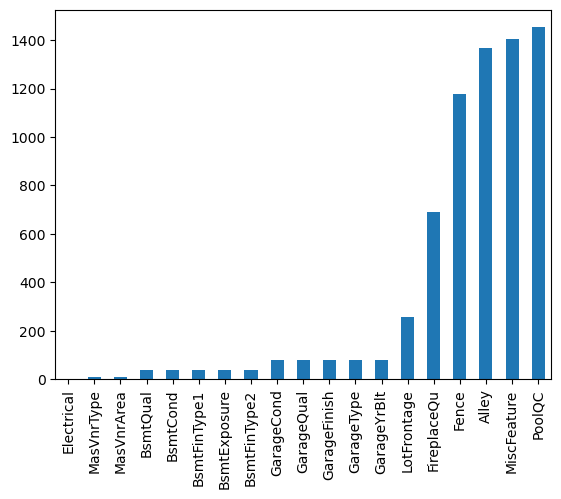

In [5]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

C:\Users\ishii\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

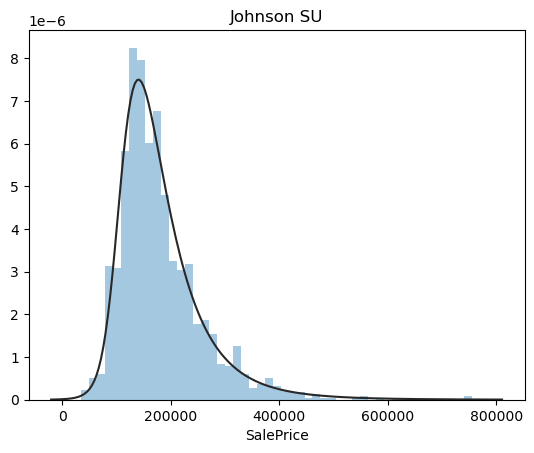

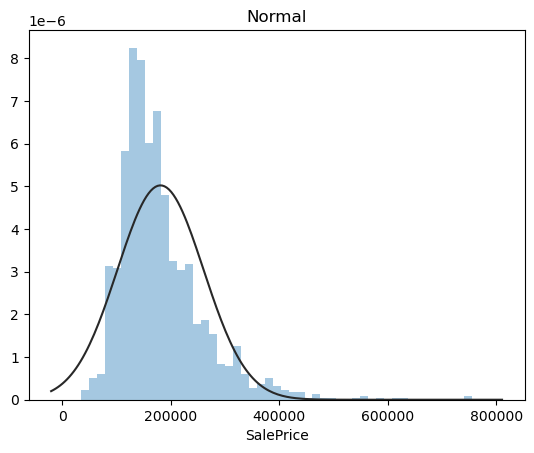

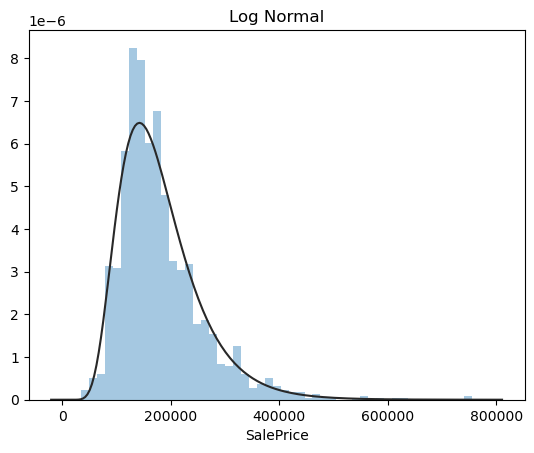

In [6]:
y = train['SalePrice']

plt.figure(1) ; plt.title ('Johnson SU')
sns.distplot (y, kde = False, fit = st.johnsonsu)

plt.figure(2) ; plt.title ('Normal')
sns.distplot (y, kde = False, fit = st.norm)

plt.figure(3) ; plt.title ('Log Normal')
sns.distplot (y, kde = False, fit = st.lognorm)

In [7]:
#正規性の検討 (シャピロウィルク検定)
#fillna(0) で欠損値を0で埋め、検定のp値が0.01より小さい場合にTrue、そうでない場合にFalseを返す
#シャピロウィルク検定では値が小さいほど正規分布に従っていない
test_normality = lambda x : st.shapiro(x.fillna(0))[1] < 0.01

#trainの量的変数をコピー
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)

#全ての値がFlaseである場合にTrueを返す
print(not normal.any())

False


C:\Users\ishii\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ishii\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ishii\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

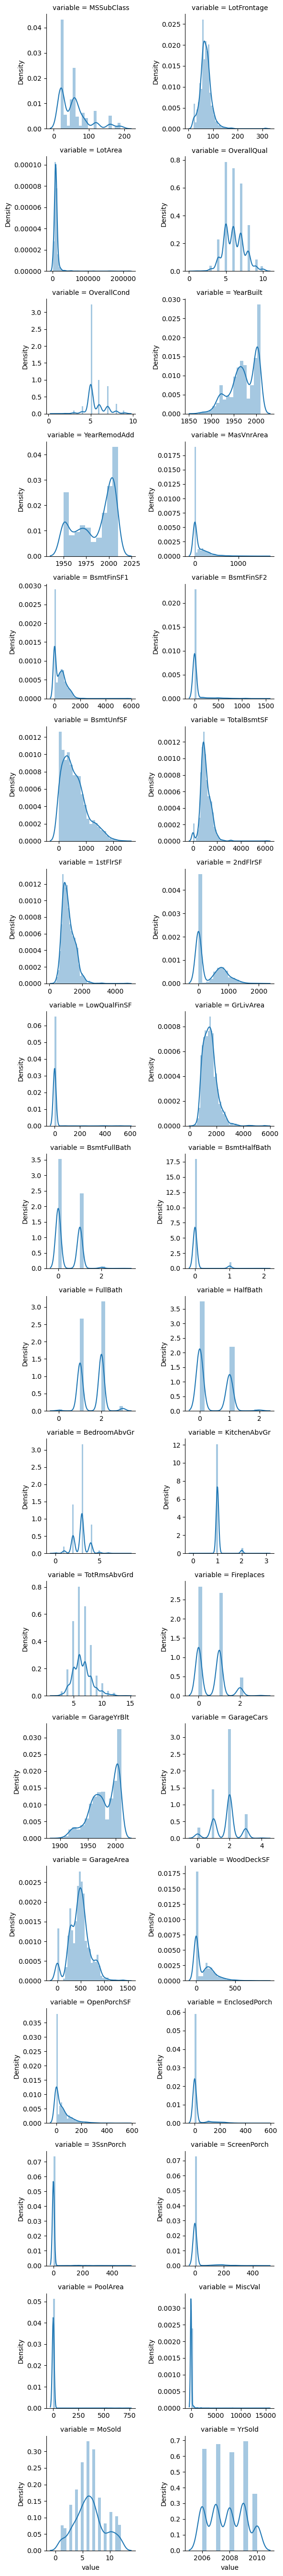

In [8]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

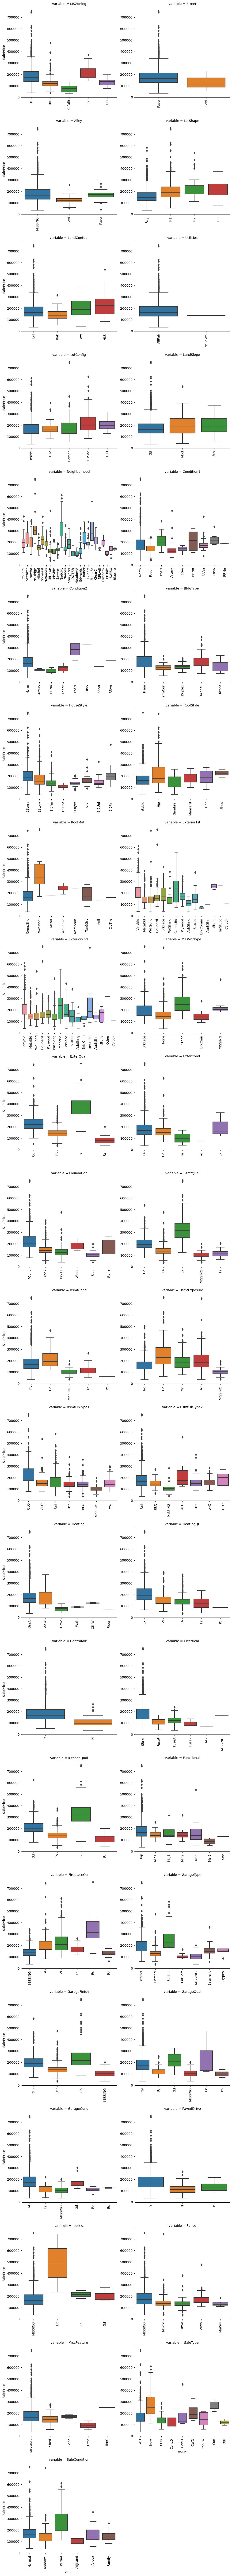

In [9]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwarsg):
    #箱ひげ図でプロット
    sns.boxplot(x=x, y=y)
    
    #x軸のラベルの向きを回転
    x=plt.xticks(rotation=90)

#"SalesPrice"以外でメルト
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)

#FacetGridは属性ごとに一気にグラフ化を行う関数
#heightは図のサイズ (従来はheightではなくsizeだった)
#col_wrapは1行にいくつのグラフを書くか (今回の場合はcol_wrap=2なので、カテゴリカル変数の数のグラフを各2行ずつで記述
#sharex=False, sharey=Falseは、それぞれx軸とy軸を共有しないことを示す
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")

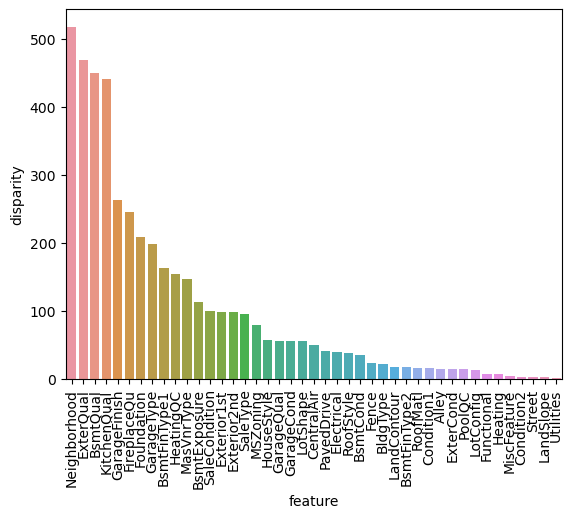

In [10]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        #samplesをそのまま引数として渡すと、リストのまま単一引数として渡される。対して、*samplesの場合は中の要素が個々の引数として渡される
        #[1]で2番目の要素 (p値) を取り出している
        pval = st.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data = a, x = 'feature', y = 'disparity')
x = plt.xticks(rotation = 90)

In [11]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0] + 1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

qual_encoded = []
for q in qualitative:
    encode(train, q)
    qual_encoded.append(q+'_E')

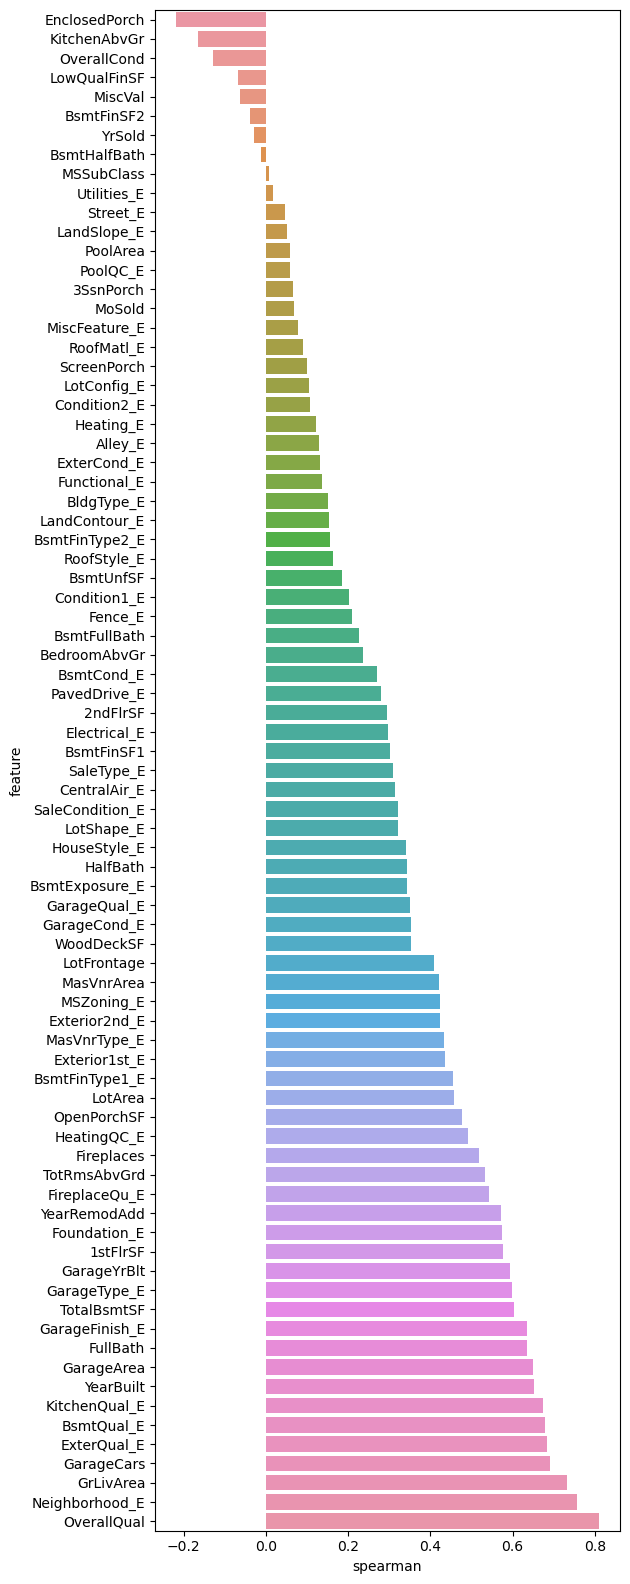

In [12]:
def spearman (frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    
    #特長量の数だけ繰り返し
    #特長量 fと目的変数 "SalePrice"のスピアマンの準位相関係数を計算
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize = (6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

features = quantitative + qual_encoded
spearman(train, features)

<AxesSubplot:>

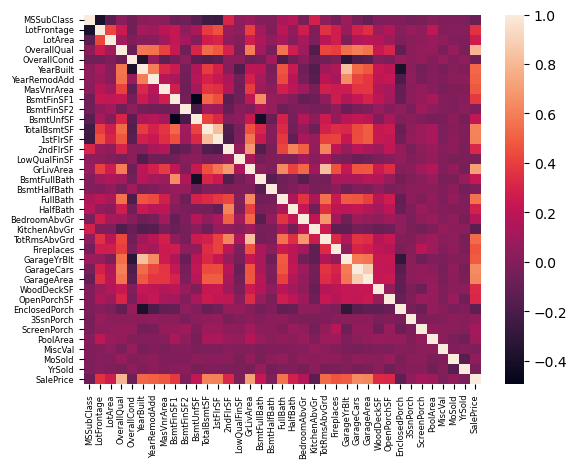

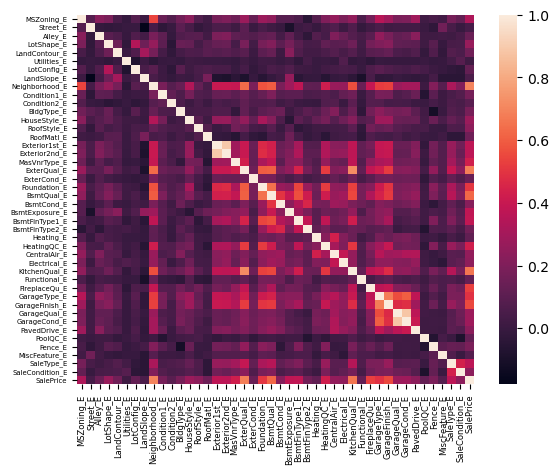

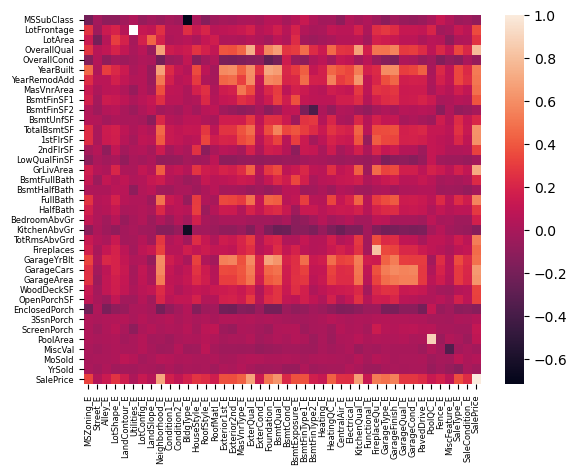

In [13]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
sns.heatmap(corr)

plt.figure(2)
corr = train[qual_encoded + ['SalePrice']].corr()
plt.xticks(fontsize=6)
plt.yticks(fontsize=5)
sns.heatmap(corr)

plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative) + 1, len(qual_encoded) + 1])
                             , index = quantitative + ['SalePrice']
                             , columns = qual_encoded + ['SalePrice'])
for q1 in quantitative + ['SalePrice']:
    for q2 in qual_encoded + ['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
sns.heatmap(corr)

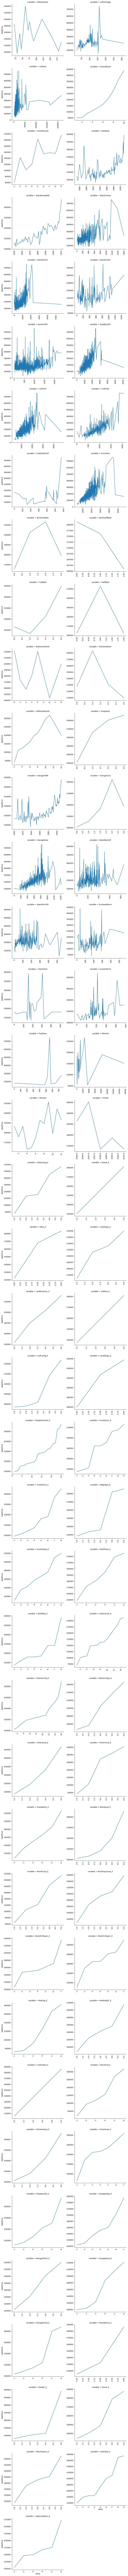

In [14]:
def pairplot (x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time' : x, 'val' : y})
    ts = ts.groupby('time').mean()
    ts.plot(ax = ax)
    plt.xticks(rotation = 90)

f = pd.melt(train, id_vars = ['SalePrice'], value_vars = quantitative + qual_encoded)
g = sns.FacetGrid(f, col = "variable", col_wrap = 2, sharex = False, sharey = False, height = 5)
g = g.map(pairplot, "value", "SalePrice")

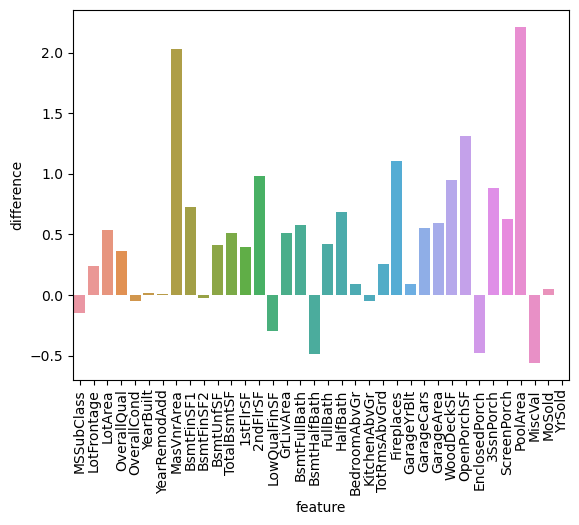

In [15]:
features = quantitative

standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean()) for f in features]

sns.barplot(data = diff, x = 'feature', y = 'difference')
x = plt.xticks(rotation = 90)

C:\Users\ishii\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ishii\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


0.7495813804755213


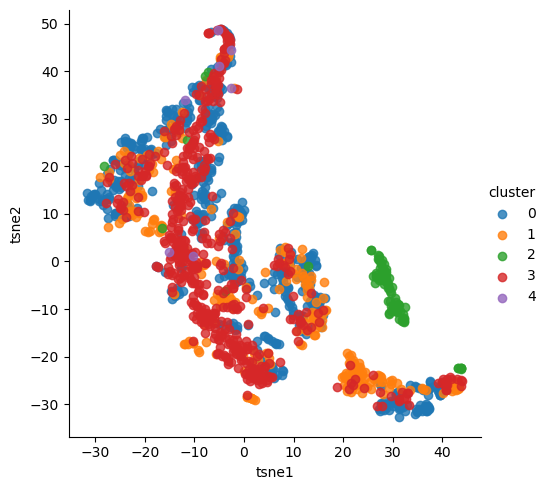

In [16]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

C:\Users\ishii\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ishii\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

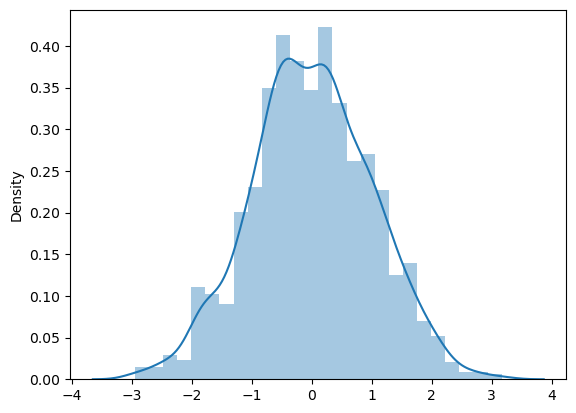

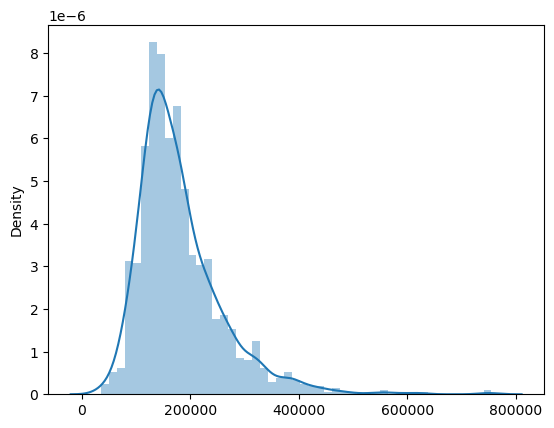

In [17]:
y = train['SalePrice'].values
def johnson(y):
    gamma, eta, epsilon, lbda = st.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

In [18]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2
    
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


features = quantitative + qual_encoded + boolean + qdr
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = train[features].fillna(0.).values
Y = train['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

C:\Users\ishii\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


0.11194749395516296

In [19]:
import patsy

Y, X = patsy.dmatrices(
    "SalePrice ~ \
        GarageCars + \
        np.log1p(BsmtFinSF1) + \
        ScreenPorch + \
        Condition1_E + \
        Condition2_E + \
        WoodDeckSF + \
        np.log1p(LotArea) + \
        Foundation_E + \
        MSZoning_E + \
        MasVnrType_E + \
        HouseStyle_E + \
        Fireplaces + \
        CentralAir_E + \
        BsmtFullBath + \
        EnclosedPorch + \
        PavedDrive_E + \
        ExterQual_E + \
        bs(OverallCond, df=7, degree=1) + \
        bs(MSSubClass, df=7, degree=1) + \
        bs(LotArea, df=2, degree=1) + \
        bs(FullBath, df=3, degree=1) + \
        bs(HalfBath, df=2, degree=1) + \
        bs(BsmtFullBath, df=3, degree=1) + \
        bs(TotRmsAbvGrd, df=2, degree=1) + \
        bs(LandSlope_E, df=2, degree=1) + \
        bs(LotConfig_E, df=2, degree=1) + \
        bs(SaleCondition_E, df=3, degree=1) + \
        OverallQual + np.square(OverallQual) + \
        GrLivArea + np.square(GrLivArea) + \
        Q('1stFlrSF') + np.square(Q('1stFlrSF')) + \
        Q('2ndFlrSF') + np.square(Q('2ndFlrSF')) +  \
        TotalBsmtSF + np.square(TotalBsmtSF) +  \
        KitchenAbvGr + np.square(KitchenAbvGr) +  \
        YearBuilt + np.square(YearBuilt) + \
        Neighborhood_E + np.square(Neighborhood_E) + \
        Neighborhood_E:OverallQual + \
        MSSubClass:BldgType_E + \
        ExterQual_E:OverallQual + \
        PoolArea:PoolQC_E + \
        Fireplaces:FireplaceQu_E + \
        OverallQual:KitchenQual_E + \
        GarageQual_E:GarageCond + \
        GarageArea:GarageCars + \
        Q('1stFlrSF'):TotalBsmtSF + \
        TotRmsAbvGrd:GrLivArea",
    train.to_dict('list'))

ridge = linear_model.RidgeCV(cv=10)
ridge.fit(X, np.log(Y))
Ypred = np.exp(ridge.predict(X))
print(error(Y,Ypred))

0.11602320727290545
